# Simple predictor

2023-12-24 by @jpgil

This notebook is an example with a real use case for the dataset. It implements a feature extraction in the logtext column (the error code, or *errcode*) and do a simple assumption to explain and predict execution failures. The method is quite simple yet powerful, and can be extended by implementing TF-IDF analysis. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Set the warning mode to 'None' to suppress the warning SettingWithCopyWarning
pd.options.mode.chained_assignment = None



## Load 1w data

In [2]:
# Dataset configuration
INSTRUMENT='GRAVITY'
RANGE='1w'

In [3]:
#####
# Hugging face dataset load
#####

#####
# Use downloaded data
#####
PATH='../data'
df_meta=pd.read_parquet(f'{PATH}/{INSTRUMENT}-{RANGE}-meta.parket')
df_inst=pd.read_parquet(f'{PATH}/{INSTRUMENT}-{RANGE}-traces.parket')
df_subs=pd.read_parquet(f'{PATH}/{INSTRUMENT}-{RANGE}-traces-SUBSYSTEMS.parket')
df_tele=pd.read_parquet(f'{PATH}/{INSTRUMENT}-{RANGE}-traces-TELESCOPES.parket')


## Filter traces by logtype: ERR

Combine, filter by logytpe: ERR and add columns errcode, errdata.

In [4]:
def get_errors_traces( list_of_traces ):
    # Concatenate all
    df_all = pd.concat(list_of_traces)

    # Sort
    df_all.sort_values('@timestamp', inplace=True)
    df_all.reset_index(drop=True, inplace=True)

    # Filter by logtype: ERR
    df_all = df_all[ df_all['logtype']=='ERR' ]

    # Extract errcode and errdata

    # Given the nature of error logs, the majority uses the pattern .+ERR_.+, but other important ERR logs must be used as is.
    df_all['errcode'] = df_all['logtext'].apply(
        lambda x: x.split()[0] if 'ERR_' in x else x  
    )
    df_all['errdata'] = df_all['logtext'].apply(
        lambda x: ' '.join(x.split()[2:]) if 'ERR_' in x else '-' 
    )

    return df_all

In [5]:
df_all = get_errors_traces([df_inst, df_subs, df_tele])

with pd.option_context('display.max_colwidth', None):
    display(df_all[['@timestamp', 'system', 'logtext', 'errcode', 'errdata', 'trace_id']])

,@timestamp,system,logtext,errcode,errdata,trace_id
351,2019-04-02 02:26:48.975,ISS,evhERR_CMD_NOT_CHECKED : Command SETUP not checked sent by proc issifControl on env wvgvlti,evhERR_CMD_NOT_CHECKED,Command SETUP not checked sent by proc issifControl on env wvgvlti,0
426,2019-04-02 02:26:55.922,AT2,"eccsERR_BUF_TOO_BIG : Buffer too big. Size: 703, Max allowed size: 176, Buffer: atagwsCON_SETUP::Set...",eccsERR_BUF_TOO_BIG,"Buffer too big. Size: 703, Max allowed size: 176, Buffer: atagwsCON_SETUP::Set...",0
435,2019-04-02 02:26:55.922,AT3,"eccsERR_BUF_TOO_BIG : Buffer too big. Size: 703, Max allowed size: 176, Buffer: atagwsCON_SETUP::Set...",eccsERR_BUF_TOO_BIG,"Buffer too big. Size: 703, Max allowed size: 176, Buffer: atagwsCON_SETUP::Set...",0
449,2019-04-02 02:26:55.925,AT1,"eccsERR_BUF_TOO_BIG : Buffer too big. Size: 703, Max allowed size: 176, Buffer: atagwsCON_SETUP::Set...",eccsERR_BUF_TOO_BIG,"Buffer too big. Size: 703, Max allowed size: 176, Buffer: atagwsCON_SETUP::Set...",0
484,2019-04-02 02:26:55.928,AT4,"eccsERR_BUF_TOO_BIG : Buffer too big. Size: 703, Max allowed size: 176, Buffer: atagwsCON_SETUP::Set...",eccsERR_BUF_TOO_BIG,"Buffer too big. Size: 703, Max allowed size: 176, Buffer: atagwsCON_SETUP::Set...",0
...,...,...,...,...,...,...
841145,2019-04-07 23:57:54.570,AT1,spaccsERR_GENERIC_STR2 : Error flag is set idle failed Sun Apr 7 23:56:58 2019,spaccsERR_GENERIC_STR2,Error flag is set idle failed Sun Apr 7 23:56:58 2019,151
841146,2019-04-07 23:57:54.570,AT1,"spaccsERR_GENERIC : Error or Alarm state is set, only state change permitted",spaccsERR_GENERIC,"Error or Alarm state is set, only state change permitted",151
841147,2019-04-07 23:57:54.571,AT1,wsf2libERR_REPLY : Error reply to command EXEC received from @wat1nao:spaccsServer,wsf2libERR_REPLY,Error reply to command EXEC received from @wat1nao:spaccsServer,151
841238,2019-04-07 23:57:55.917,ISS,evhERR_CMD_NOT_CHECKED : Command SETUP not checked sent by proc issifControl on env wvgvlti,evhERR_CMD_NOT_CHECKED,Command SETUP not checked sent by proc issifControl on env wvgvlti,151


## Find harmless error codes

Consider just successful executions, collect all errcodes in the related traces. Those are "harmless", i.e. they don't make an execution to fail.

In [6]:
def get_harmless_errcodes(meta, traces):
    # Filter de_meta by ERROR=False
    err_false_ids = meta[ meta['ERROR'] == False ].index.values

    # Filter traces to ERROR=False ids
    df_traces_err_false = traces[traces['trace_id'].isin(err_false_ids)]

    # Collect the errors strings
    harmless_errcodes = df_traces_err_false['errcode'].unique()
    
    return harmless_errcodes

In [7]:
harmless_errcodes=get_harmless_errcodes(df_meta, df_all)
len(harmless_errcodes), harmless_errcodes[:20]

(163,
 array(['evhERR_CMD_NOT_CHECKED', 'tcsmonERR_ENVIRONMENT',
        'eccsERR_BUF_TOO_BIG', 'dlpomERR_MODEL_NAME', 'ccsERR_DB_QUALITY',
        'pyccsERR_GUI', 'lcctooERR_SEM_TAKE', 'ic0lcuERR_SEM_CMD_LOCKED',
        'ataltsrvERR_PT100', 'ataltsrvERR_TIMEOUT', 'trkERR_VXWORKS',
        'irisERR_ACTIVE', 'iriswsERR_COMMAND', 'ccsERR_DB_INV_NAME',
        'ccsERR_DB_QUERY', 'trkERR_INTERNAL', 'ccsERR_DB_LCU',
        'ccsERR_REMOTE_LINK', 'seqERR_DB_READ_SYMBOLIC',
        'evhERR_ERROR_HANDLING'], dtype=object))

## Suspicious errcodes
Up to now, we have the needed information to label a given error as "harmless" or "suspicious" to be the root cause on a failed execution. All errcodes can be splitted in those two classes.

In [8]:
# Filter traces to not harmless error codes 
df_traces_err_true = df_all[ ~ df_all['errcode'].isin(list(harmless_errcodes))]

show_rows=min(20, len(df_traces_err_true))

# Show suspicious error codes
with pd.option_context('display.max_colwidth', None):
    display(df_traces_err_true[['@timestamp', 'system', 'errcode', 'errdata', 'trace_id']][:show_rows])
    print(f'Showing {show_rows} of {len(df_traces_err_true)} rows\n')


,@timestamp,system,errcode,errdata,trace_id
5677,2019-04-02 02:39:15.711,GRAVITY,ixacERR_STORE_EXTR_BUF,"Invalid buffer ',...'. The list of keywords must be given as 'keyw1 value1 keyw2 value2 ...'""",1
5735,2019-04-02 02:39:24.207,GRAVITY,ccsERR_DB_OPEN,Failure opening (wgv) database,1
5736,2019-04-02 02:39:24.207,GRAVITY,ccsERR_DB_OPEN,Failure opening (wgv) database,1
5737,2019-04-02 02:39:24.207,GRAVITY,ccsERR_DB_GET_HANDLE,Cannot get handle for environment (wgv),1
5738,2019-04-02 02:39:24.207,GRAVITY,ccsERR_DB_OPEN,Failure opening () database,1
5912,2019-04-02 02:39:56.288,GRAVITY,ixacERR_STORE_EXTR_BUF,"Invalid buffer ',...'. The list of keywords must be given as 'keyw1 value1 keyw2 value2 ...'""",1
5918,2019-04-02 02:39:56.299,GRAVITY,ixacERR_STORE_EXTR_BUF,"Invalid buffer ',...'. The list of keywords must be given as 'keyw1 value1 keyw2 value2 ...'""",1
5934,2019-04-02 02:39:57.535,GRAVITY,ixacERR_STORE_EXTR_BUF,"Invalid buffer ',...'. The list of keywords must be given as 'keyw1 value1 keyw2 value2 ...'""",1
18007,2019-04-02 03:09:03.357,GRAVITY,: Error during setup. (states) (red),-,5
18010,2019-04-02 03:09:03.370,GRAVITY,Error during setup. (states) (red),-,5


Showing 20 of 1021 rows



## Analysis: Predictive capability

It is measured in seconds, the time between first appearence of not harmless error and the end of the execution

In [9]:
# All failed executions
df_failed = df_meta[df_meta['ERROR']==True]

# Not harmless errors traces dataframe
df_traces_unknownErr = df_all[ ~ df_all['errcode'].isin(list(harmless_errcodes))]

def first_timestamp(id):
    df = df_traces_unknownErr[ df_traces_err_true['trace_id']==id ]
    if len(df) == 0:
        return -1
    else:
        fromT = df['@timestamp'].values[0]
        endT  = df_failed[df_failed.index==id]['END'].values[0]
        return (endT-fromT).astype('timedelta64[s]').item().total_seconds()
    
def unknown_error(id):
    df = df_traces_unknownErr[ df_traces_err_true['trace_id']==id ]
    if len(df) == 0:
        return -1
    else:
        return df[['system', 'errcode', 'errdata']][0:1].values


df_failed['predictive seconds'] = df_failed.index.map( first_timestamp )
df_failed['first unknown error'] = df_failed.index.map( unknown_error )

with pd.option_context('display.max_colwidth', None):
    display(df_failed[['END', 'system', 'SECONDS', 'predictive seconds', 'first unknown error']])

,END,system,SECONDS,predictive seconds,first unknown error
0,2019-04-02 02:36:25.647,GRAVITY,589.0,-1.0,-1
1,2019-04-02 02:40:29.255,GRAVITY,243.0,73.0,"[[GRAVITY, ixacERR_STORE_EXTR_BUF, Invalid buffer ',...'. The list of keywords must be given as 'keyw1 value1 keyw2 value2 ...'""]]"
5,2019-04-02 03:09:03.371,GRAVITY,271.0,0.0,"[[GRAVITY, : Error during setup. (states) (red), -]]"
6,2019-04-02 03:10:27.129,GRAVITY,13.0,8.0,"[[AT3, spaccsERR_GENERIC_STR, Error occurred in callback for SETUP]]"
13,2019-04-02 05:15:59.923,GRAVITY,1004.0,-1.0,-1
15,2019-04-02 06:02:12.205,GRAVITY,2354.0,2014.0,"[[GRAVITY, gvacqERR_RTDCORE_LIB, Failed to lock access semaphore]]"
38,2019-04-03 01:43:39.813,GRAVITY,502.0,-1.0,-1
55,2019-04-04 00:22:34.341,GRAVITY,41.0,38.0,"[[GRAVITY, gvimtfsERR_GENERAL, Device mtfs: Error reading from serial port.]]"
56,2019-04-04 00:24:18.874,GRAVITY,43.0,39.0,"[[GRAVITY, gvimtfsERR_GENERAL, Device mtfs: Error reading from serial port.]]"
57,2019-04-04 01:26:24.699,GRAVITY,45.0,22.0,"[[GRAVITY, gviserERR_COM_TIMEOUT, Serial device timeout (fd=47).]]"


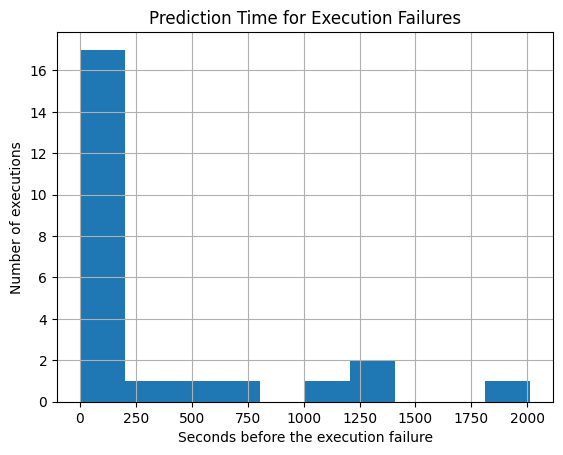

In [10]:
df_failed['predictive seconds'].hist()
plt.title("Prediction Time for Execution Failures")
plt.xlabel("Seconds before the execution failure")
plt.ylabel("Number of executions")
plt.show()

However, some predictions could be fake. Assuming that 10% are bad predictions, let's see the 90% of worst predictions which is more realistic.

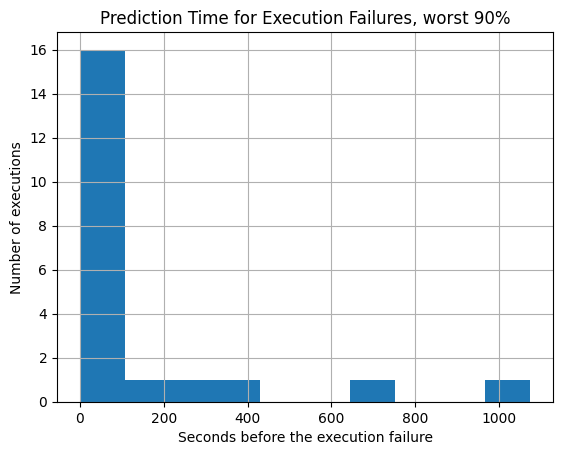

In [11]:
df_90 = df_failed.sort_values('predictive seconds')
df_90 = df_90[:int(len(df_90)*0.9)]

df_90['predictive seconds'].hist()
plt.title("Prediction Time for Execution Failures, worst 90%")
plt.xlabel("Seconds before the execution failure")
plt.ylabel("Number of executions")
plt.show()

The numbers shown in the graph above separates the prediction in two: below 60 seconds, the errcodes are not useful to predict but it can help in the  post mortem analysis. Above 60 seconds it can warn the operator that a failure is likely appear saving up to minutes of time.

## Analysis: False negatives


### Rationale
It is expected that total failed executions matched failed with suspicious errcodes. However that is not always true, and some errcodes considered as "harmless" are actually the reason behind the failure. The explanation is that the model was trained only with errcodes, but some errdata has values that makes the execution fails.

### Split failed executions with suspicious errcodes
Quick check: how many failed executions contains no harmless errcodes

In [12]:
# Obtain the trace_ids for suspicious errcodes
id_list = df_traces_err_true['trace_id'].unique()

# All failed executions
df_failed = df_meta[df_meta['ERROR']==True]

# Split df_meta
df_failed_with_suspicious_errcode    = df_failed[   df_failed.index.isin(id_list) ]
df_failed_without_suspicious_errcode = df_failed[ ~ df_failed.index.isin(id_list) ]

Total Failed executions: 24, failed with suspicious errcodes: 20


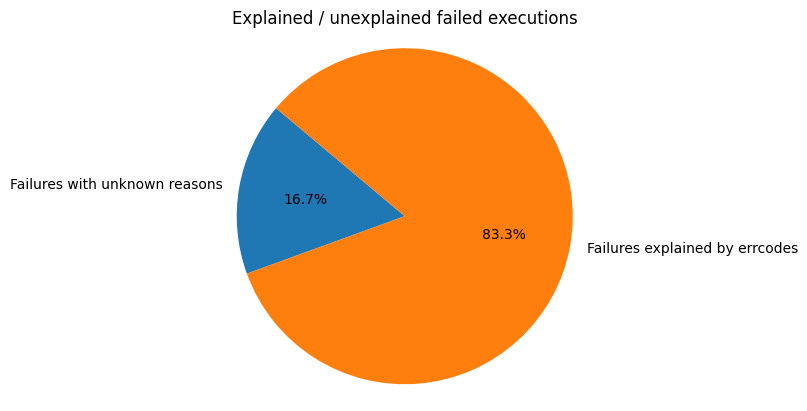

In [13]:

print(f'Total Failed executions: {len(df_failed)}, failed with suspicious errcodes: {len(df_failed_with_suspicious_errcode)}')

# Data
data = [len(df_failed)-len(df_failed_with_suspicious_errcode), len(df_failed_with_suspicious_errcode)]
labels = ["Failures with unknown reasons", "Failures explained by errcodes"]

plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Explained / unexplained failed executions")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### Detail of errcodes and errdata

In [14]:
print('\nFirst 5 Failures without suspicious errcode:')
df = df_failed_without_suspicious_errcode[:5]
display(df)

for id in df.index.values:
    with pd.option_context('display.max_colwidth', None):
        print(f'\n===========\nObservation #{id}')
        display(df[df.index==id])

        LAST_ERR=10
        print(f"Last {LAST_ERR} errors for obs #{id}")
        df_thisobs = df_all[df_all['trace_id']==id][-LAST_ERR:]
        df_thisobs['harmless'] = df_thisobs['errcode'].isin(harmless_errcodes)
        df_thisobs['errcode frequency'] = df_thisobs['errcode'].apply(lambda x: len(df_all[ df_all['errcode']==x ]) )
        display(df_thisobs[['@timestamp', 'errcode frequency', 'errcode', 'errdata', 'harmless']])



First 5 Failures without suspicious errcode:


,START,END,TIMEOUT,system,procname,TPL_ID,ERROR,Aborted,SECONDS,TEL
0,2019-04-02 02:26:35.908,2019-04-02 02:36:25.647,False,GRAVITY,bob_26244,GRAVITY,True,False,589.0,AT
13,2019-04-02 04:59:14.976,2019-04-02 05:15:59.923,False,GRAVITY,bob_15976,GRAVITY_dual_acq,True,False,1004.0,AT
38,2019-04-03 01:35:17.762,2019-04-03 01:43:39.813,False,GRAVITY,bob_46956,GRAVITY_single_acq,True,False,502.0,AT
129,2019-04-07 05:36:24.132,2019-04-07 05:59:22.430,False,GRAVITY,bob_46264,GRAVITY_single_obs_exp,True,False,1378.0,AT



Observation #0


,START,END,TIMEOUT,system,procname,TPL_ID,ERROR,Aborted,SECONDS,TEL
0,2019-04-02 02:26:35.908,2019-04-02 02:36:25.647,False,GRAVITY,bob_26244,GRAVITY,True,False,589.0,AT


Last 10 errors for obs #0


,@timestamp,errcode frequency,errcode,errdata,harmless
3706,2019-04-02 02:35:12.900,74,totsERR_MATCHFAILED,"failed to get valid sensor response, got",True
3722,2019-04-02 02:35:14.650,74,totsERR_MISC,failed to get temperature,True
3723,2019-04-02 02:35:14.650,74,totsERR_MATCHFAILED,"failed to get valid sensor response, got 11X04?+9",True
3908,2019-04-02 02:35:44.607,297,evhERR_ERROR_HANDLING,This error stack contain not-handled errors. Forcing CloseStack(),True
3909,2019-04-02 02:35:44.607,19,dlpomERR_GETPOS,Failure getting new positions from opd LCU,True
3910,2019-04-02 02:35:44.607,19,evhERR_HANDLE_COMMAND,"Instance already handling another command (old: GETPOS, new GETPOS)",True
4030,2019-04-02 02:36:04.440,3771,tcsmonERR_ENVIRONMENT,enviroment data at least one ASM parameter out of range,True
4098,2019-04-02 02:36:15.688,19,dlpomERR_GETPOS,Failure getting new positions from opd LCU,True
4099,2019-04-02 02:36:15.688,19,evhERR_HANDLE_COMMAND,"Instance already handling another command (old: GETPOS, new GETPOS)",True
4102,2019-04-02 02:36:15.689,297,evhERR_ERROR_HANDLING,This error stack contain not-handled errors. Forcing CloseStack(),True



Observation #13


,START,END,TIMEOUT,system,procname,TPL_ID,ERROR,Aborted,SECONDS,TEL
13,2019-04-02 04:59:14.976,2019-04-02 05:15:59.923,False,GRAVITY,bob_15976,GRAVITY_dual_acq,True,False,1004.0,AT


Last 10 errors for obs #13


,@timestamp,errcode frequency,errcode,errdata,harmless
47645,2019-04-02 05:12:32.650,82,ccsERR_DB_INV_NAME,Illegal DB name ( '<alias>FTWF:status0'),True
47671,2019-04-02 05:12:35.954,14,seqERR_REPLY_TIMEOUT,reply on cmd1 (CALIBSN to lgvft2/gviopdcServer) timed out after 10000 ms,True
47844,2019-04-02 05:12:58.156,73,ataltsrvERR_TIMEOUT,Timeout on Analog Input data,True
47845,2019-04-02 05:12:58.156,73,ataltsrvERR_PT100,Failure reading PT100 temperature sensor '',True
47912,2019-04-02 05:13:04.438,3771,tcsmonERR_ENVIRONMENT,enviroment data at least one ASM parameter out of range,True
47921,2019-04-02 05:13:04.925,297,evhERR_ERROR_HANDLING,This error stack contain not-handled errors. Forcing CloseStack(),True
47922,2019-04-02 05:13:04.925,19,dlpomERR_GETPOS,Failure getting new positions from opd LCU,True
47923,2019-04-02 05:13:04.925,19,evhERR_HANDLE_COMMAND,"Instance already handling another command (old: GETPOS, new GETPOS)",True
48418,2019-04-02 05:14:04.437,3771,tcsmonERR_ENVIRONMENT,enviroment data at least one ASM parameter out of range,True
48892,2019-04-02 05:15:04.435,3771,tcsmonERR_ENVIRONMENT,enviroment data at least one ASM parameter out of range,True



Observation #38


,START,END,TIMEOUT,system,procname,TPL_ID,ERROR,Aborted,SECONDS,TEL
38,2019-04-03 01:35:17.762,2019-04-03 01:43:39.813,False,GRAVITY,bob_46956,GRAVITY_single_acq,True,False,502.0,AT


Last 10 errors for obs #38


,@timestamp,errcode frequency,errcode,errdata,harmless
159191,2019-04-03 01:42:04.440,3771,tcsmonERR_ENVIRONMENT,enviroment data at least one ASM parameter out of range,True
159512,2019-04-03 01:42:58.896,14,seqERR_REPLY_TIMEOUT,reply on cmd1 (CALIBSN to lgvft2/gviopdcServer) timed out after 10000 ms,True
159520,2019-04-03 01:42:59.616,14,seqERR_EVENT_SCRIPT_EVAL,"evaluation of event106's script ""namespace inscope ::dlguiUserDL {::.dlguiUser.top.wdg.can.dlguiU"" failed (another sound i",True
159545,2019-04-03 01:43:04.442,3771,tcsmonERR_ENVIRONMENT,enviroment data at least one ASM parameter out of range,True
159736,2019-04-03 01:43:36.412,19,dlpomERR_GETPOS,Failure getting new positions from opd LCU,True
159737,2019-04-03 01:43:36.412,19,evhERR_HANDLE_COMMAND,"Instance already handling another command (old: GETPOS, new GETPOS)",True
159738,2019-04-03 01:43:36.413,297,evhERR_ERROR_HANDLING,This error stack contain not-handled errors. Forcing CloseStack(),True
159740,2019-04-03 01:43:36.422,19,evhERR_HANDLE_COMMAND,"Instance already handling another command (old: GETPOS, new GETPOS)",True
159741,2019-04-03 01:43:36.422,297,evhERR_ERROR_HANDLING,This error stack contain not-handled errors. Forcing CloseStack(),True
159742,2019-04-03 01:43:36.422,19,dlpomERR_GETPOS,Failure getting new positions from opd LCU,True



Observation #129


,START,END,TIMEOUT,system,procname,TPL_ID,ERROR,Aborted,SECONDS,TEL
129,2019-04-07 05:36:24.132,2019-04-07 05:59:22.430,False,GRAVITY,bob_46264,GRAVITY_single_obs_exp,True,False,1378.0,AT


Last 10 errors for obs #129


,@timestamp,errcode frequency,errcode,errdata,harmless
746681,2019-04-07 05:54:04.441,3771,tcsmonERR_ENVIRONMENT,enviroment data at least one ASM parameter out of range,True
747060,2019-04-07 05:55:04.438,3771,tcsmonERR_ENVIRONMENT,enviroment data at least one ASM parameter out of range,True
747409,2019-04-07 05:56:04.440,3771,tcsmonERR_ENVIRONMENT,enviroment data at least one ASM parameter out of range,True
747736,2019-04-07 05:57:04.441,3771,tcsmonERR_ENVIRONMENT,enviroment data at least one ASM parameter out of range,True
748056,2019-04-07 05:58:04.442,3771,tcsmonERR_ENVIRONMENT,enviroment data at least one ASM parameter out of range,True
748397,2019-04-07 05:59:04.443,3771,tcsmonERR_ENVIRONMENT,enviroment data at least one ASM parameter out of range,True
748406,2019-04-07 05:59:05.582,32,issprsERR_WARNING,Set an empty target list.,True
748407,2019-04-07 05:59:05.622,536,slxERR_KEYWORD_NOT_FOUND,"The keyword ""ESO.ISS.DID"" was not found in Dictionary loaded into Hash Table.",True
748408,2019-04-07 05:59:05.622,536,slxERR_KEYWORD_NOT_FOUND,"The keyword ""ESO.ISS.ID"" was not found in Dictionary loaded into Hash Table.",True
748438,2019-04-07 05:59:11.285,297,evhERR_ERROR_HANDLING,This error stack contain not-handled errors. Forcing CloseStack(),True
